In [46]:
from utils._model import build_and_compile_model, train_model_with_kfold, train_models_with_kfold, display_summaries, build_and_compile_model_custom
from utils._evaluation import evaluate_models, generate_reports, generate_single_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils._image import display_images_from_subfolders
from sklearn.model_selection import train_test_split
from utils._data import get_subfolders, load_data
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from utils._plot import plot

In [38]:
import yaml

with open("config.yaml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_dir = 'Testing/'
training_dir = 'Training/'

In [ ]:
subfolders = get_subfolders(training_dir)
display_images_from_subfolders(training_dir, subfolders)

## Creating training and testing data frames

In [ ]:
X_train, y_train = load_data(training_dir, labels)
X_test, y_test = load_data(testing_dir, labels)

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = to_categorical(y_train) # One-hot encoding of integer labels
y_test = to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_gen.fit(X_train)

## Model Creation

In [ ]:
models = {
    'EfficientNet': build_and_compile_model(architecture='EfficientNet', config=config),
    'DenseNet': build_and_compile_model(architecture='DenseNet', config=config),
    'MobileNet': build_and_compile_model(architecture='MobileNet', config=config),
    'ResNet50': build_and_compile_model(architecture='ResNet50', config=config)
}

display_summaries(models)

## Model Training

Instead of training each model once on a static train/validation split, each model will now be trained and evaluated n_splits times. Each time it will be with a different train/validation set derived from the original X_train and y_train. In other words, we split the data into k subsets and validate the model k times.

In [ ]:
all_metrics = train_models_with_kfold(models, X_train, y_train, image_gen=image_gen, config=config)

evaluate_models(models, X_test, y_test)
generate_reports(all_metrics, X_test, y_test, models)

## Create custom Convolutional Neural Network

In [50]:
model = build_and_compile_model_custom(num_conv_blocks=5, num_dense_layers=2, config=config)
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 64)    

Training CustomNet on Fold 1
Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 1.1675 - accuracy: 0.5436 - auc: 0.7914
Epoch 1: val_loss improved from inf to 2.72469, saving model to CustomNet.h5
128/128 [==============================] - 131s 1s/step - loss: 1.1675 - accuracy: 0.5436 - auc: 0.7914 - val_loss: 2.7247 - val_accuracy: 0.3896 - val_auc: 0.6114 - lr: 0.0010
Epoch 2/10


/Users/dzenis.madzovic/Desktop/Other Projects/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - ETA: 0s - loss: 0.9296 - accuracy: 0.6437 - auc: 0.8698
Epoch 2: val_loss did not improve from 2.72469
128/128 [==============================] - 128s 992ms/step - loss: 0.9296 - accuracy: 0.6437 - auc: 0.8698 - val_loss: 4.6881 - val_accuracy: 0.2364 - val_auc: 0.5476 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.6911 - auc: 0.8982
Epoch 3: val_loss did not improve from 2.72469
128/128 [==============================] - 125s 973ms/step - loss: 0.8225 - accuracy: 0.6911 - auc: 0.8982 - val_loss: 3.5283 - val_accuracy: 0.2805 - val_auc: 0.5689 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.7120 - auc: 0.9110
Epoch 4: val_loss improved from 2.72469 to 1.20332, saving model to CustomNet.h5
128/128 [==============================] - 126s 984ms/step - loss: 0.7669 - accuracy: 0.7120 - auc: 0.9110 - val_loss: 1.2033 - val_accuracy: 0.58

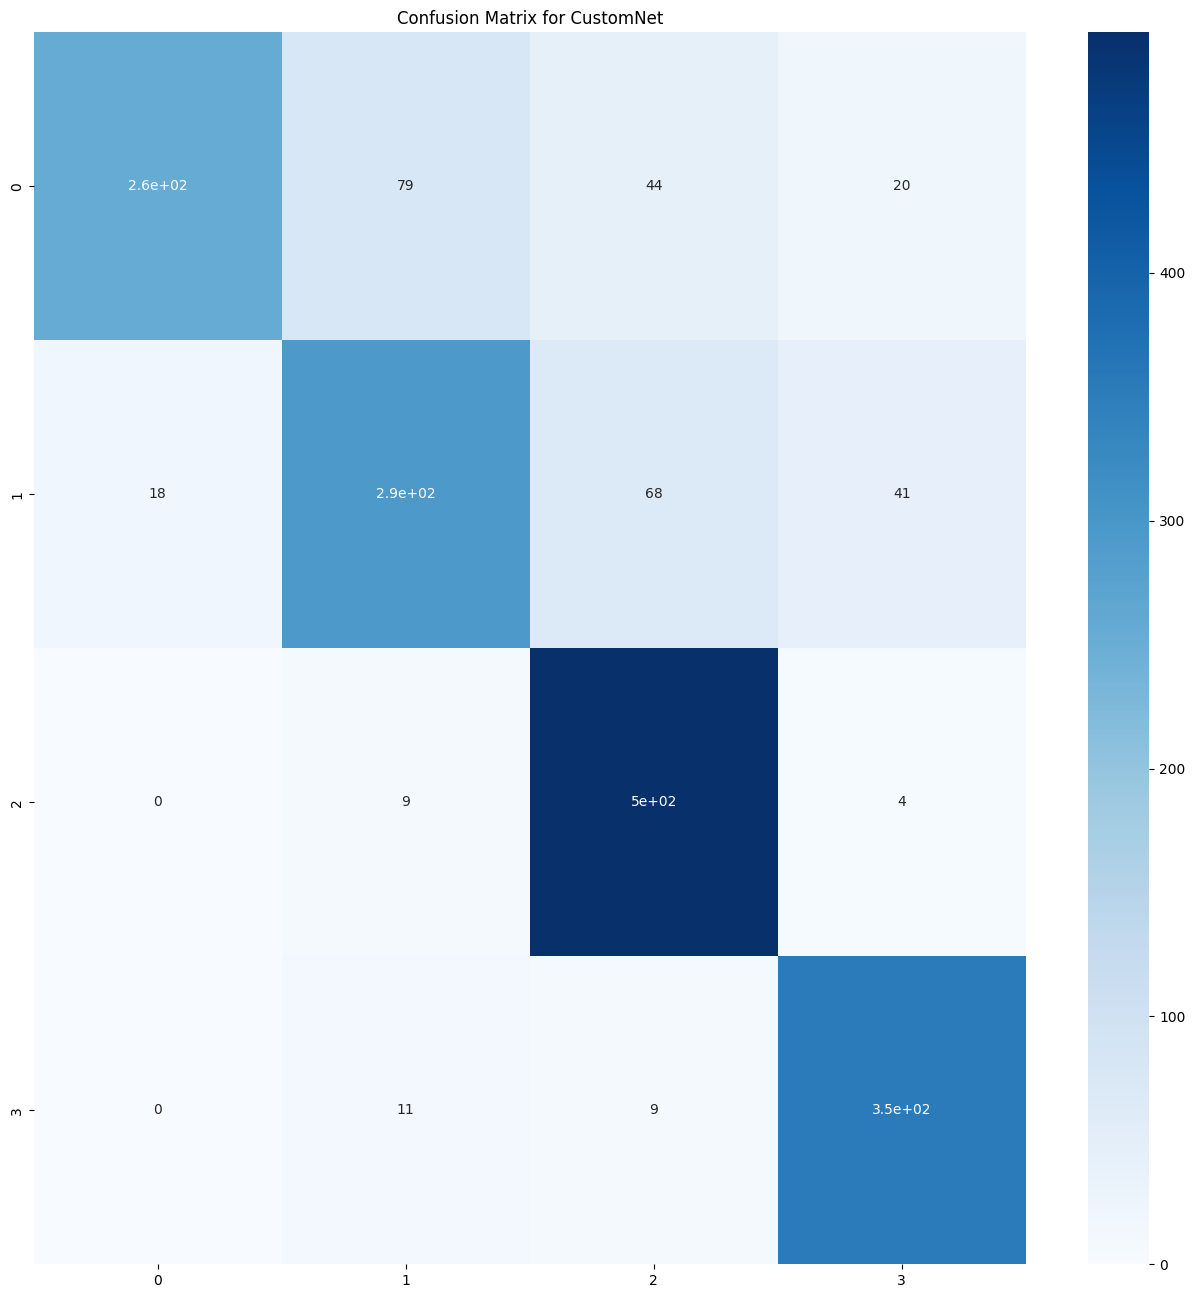

Classification Report for CustomNet:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       399
           1       0.75      0.70      0.72       421
           2       0.80      0.97      0.88       510
           3       0.84      0.95      0.89       374

    accuracy                           0.82      1704
   macro avg       0.83      0.82      0.81      1704
weighted avg       0.83      0.82      0.82      1704



In [51]:
metrics = train_model_with_kfold(model, 'CustomNet', X_train, y_train, image_gen, n_splits=5, config=config)
generate_single_report('CustomNet', metrics, model, X_test, y_test)